# 3D-deconvolution with prior learned GAN

## create deconvolution model
tf.fft_shift needs even number of dims, so eventually cut an array (then create new otf)

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import sys
from glob import glob
from skimage import io
import json 
import pprint
from keras import optimizers, losses

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
%load_ext autoreload
%autoreload 2

sys.path.insert(0, './scripts')

import helper as hp
import deconvolution
from NanoImagingPack.microscopy import PSF3D
from NanoImagingPack.view import view

import warnings
warnings.filterwarnings("ignore")

#### load and image, GAN model, reconstruct the OTF and create deconvolution model 

In [3]:
day = '2018_10_30'
filename_D = '13_52_55_disc'
filename_G = '13_52_55_gene'
filename_C = '13_53_02_combined'

generator = hp.model_loader(day, filename_G)
discriminator = hp.model_loader(day, filename_D)
combined = hp.model_loader(day, filename_C)

Loaded model from disk: 13_52_55_gene
Loaded model from disk: 13_52_55_disc
Loaded model from disk: 13_53_02_combined


In [4]:
with open('./models/{0}/hyperparameter_13_52_55.json'.format(day)) as json_data:
    json_file = json.load(json_data)
    otf_info = json_file['OTF']
    hparam = json_file['hyper_parameter']
    pprint.pprint(otf_info)
#     pprint.pprint(hyperparameter)
    
vol_original = (hparam['RESIZE']['width'],
                hparam['RESIZE']['height'],
                hparam['RESIZE']['depth'])    

# CAUTION: OTF is already shifted
otf = PSF3D(im=vol_original,
            NA=otf_info['NA'],
            wavelength=otf_info['wavelength'],
            ret_val=otf_info['ret_val'])

otf = otf/np.max(np.abs(otf))
otf = np.fft.fftshift(otf)

otf.shape

{'NA': 1.0,
 'focal_plane': 'disc',
 'n': 1.0,
 'px_size': [50, 50, 100],
 'ret_val': 'OTF',
 'wavelength': 500}


(64, 64, 32)

In [5]:
# adam = optimizers.Adam(hparam['ADAM_OPTIMIZER_LEARNRATE'], 0.5)

# discriminator.compile(loss=hparam['D_LOSS'], optimizer=adam, metrics=['accuracy'])
# combined.compile(loss=hparam['COMBINED_LOSS'], loss_weights=hparam['LOSS_WEIGHTS'], optimizer=adam)
# generator.compile(loss='mae', optimizer=adam)

In [6]:
# load an image

v_path = np.random.choice(glob('./data/3D/VALIDATION/dub/*'), size=1)[0]
print(v_path)
vol = np.swapaxes(io.imread(v_path), 0, 2)
print(vol.shape)
vol = hp.cut_volume(vol, vol_original)
print(vol.shape,'\t', np.min(vol),'\t', np.max(vol))

./data/3D/VALIDATION/dub\dub74.tif
(768, 512, 33)
(64, 64, 32) 	 0 	 220


In [7]:
%%time

# execute prediction with generator
t = np.expand_dims(np.expand_dims(vol, axis=0), axis=-1)
x = generator.predict(t).squeeze()

Wall time: 1.38 s


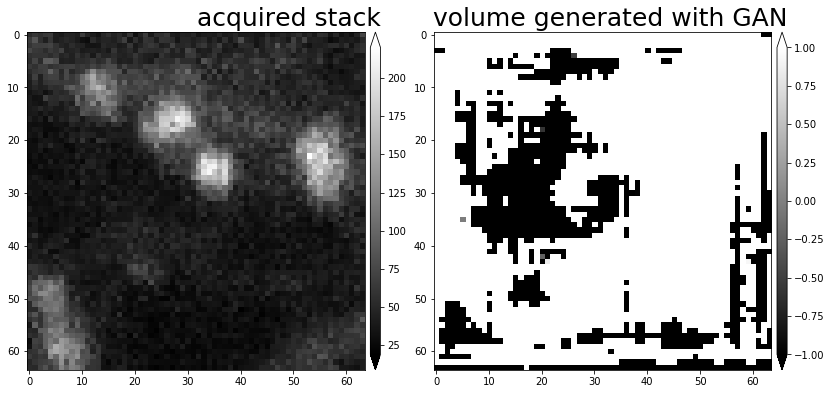

In [8]:
f = plt.figure(figsize=(12,8))
plt.subplot(121); 
temp = plt.imshow(np.max(t.squeeze(), axis=2), cmap='gray'); 
hp.colorbar(temp); plt.xticks([]); plt.yticks([]); plt.title('acquired stack', fontsize=25, loc='right');
plt.subplot(122); 
temp = plt.imshow(np.max(x, axis=2), cmap='gray'); 
hp.colorbar(temp); plt.xticks([]); plt.yticks([]); plt.title('volume generated with GAN', fontsize=25, loc='right')
plt.subplots_adjust(left=0.02, wspace=0.15, top=0.92)
plt.show()

In [9]:
# check shapes for deconvolution model
# CAUTION: check if the axes of vol must be swaped
#     if yes: swap it, before commit it to the deconvolution-model

print('vol:\t', vol.shape)
print('otf:\t', otf.shape)
print('x\t', x.shape)

vol:	 (64, 64, 32)
otf:	 (64, 64, 32)
x	 (64, 64, 32)


In [52]:
# release GPU
import gc

gc.collect()

47519

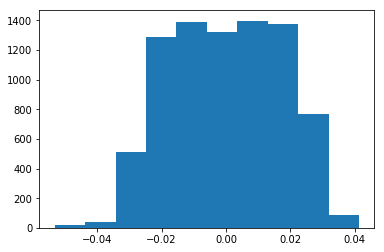

In [10]:
# print(generator.layers)
t = generator.layers[-2].get_weights()[0].squeeze()
plt.hist(t.flatten())
plt.show()

## declare iterative Deconvolution model and build graph


Successfully build tensorflow-graph for iterative Deconvolution

epoch: 0 ,	loss: 5766060.5
D: 0.003111072


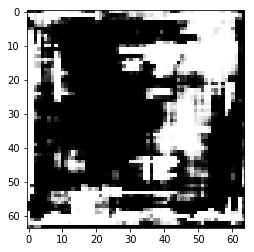

epoch: 100 ,	loss: 5766060.0
D: 0.0029578656
epoch: 200 ,	loss: 5766059.5
D: 0.0028052963


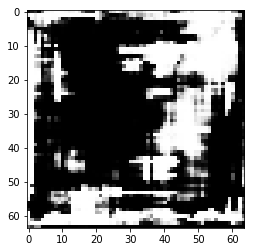

epoch: 300 ,	loss: 5766059.0
D: 0.0026545487
epoch: 400 ,	loss: 5766058.5
D: 0.0025055632


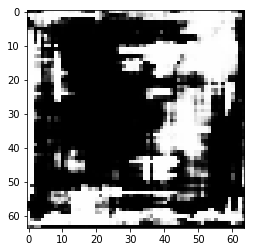

epoch: 500 ,	loss: 5766058.0
D: 0.0023596026
epoch: 600 ,	loss: 5766058.0
D: 0.0022163615


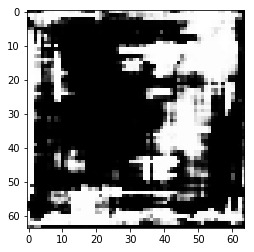

epoch: 700 ,	loss: 5766057.5
D: 0.0020747483
epoch: 800 ,	loss: 5766056.5
D: 0.0019344762


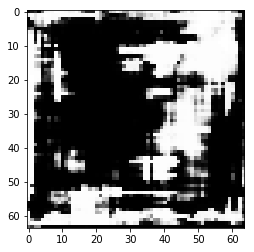

epoch: 900 ,	loss: 5766055.5
D: 0.0017980821


In [31]:
model = deconvolution.Deconvolution_3D(vol=vol, 
                                        otf=otf,
                                        generator=generator,
                                        discriminator=discriminator,
                                        lam_TV=0.5,
                                        lam_GAN=1.)

model.optimize(epochs=1000)

Tensor("add_17:0", dtype=float32)
0 [0.3] [-0.3]
50 [-0.7092198] [0.14507076]
100 [-0.84079814] [0.53192717]
150 [-0.91283715] [0.74373066]
200 [-0.95227844] [0.8596927]


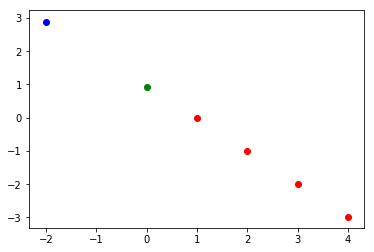

In [92]:
import tensorflow as tf

# Model parameters
W = tf.Variable([.3], tf.float32)
b = tf.Variable([-.3], tf.float32)
# Model input and output
x = tf.placeholder(tf.float32)
linear_model = W * x + b
y = tf.placeholder(tf.float32)
# loss
loss = tf.reduce_sum(tf.square(linear_model - y)) # sum of the squares
# optimizer
optimizer = tf.train.GradientDescentOptimizer(0.01)
train = optimizer.minimize(loss)
# training data
x_train = [1,2,3,4]
y_train = [0,-1,-2,-3]
# training loop
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init) # reset values to wrong
print(linear_model)
for i in range(250):
    r = sess.run([train, W, b], {x:x_train, y:y_train})
    if i % 50 == 0:
        print(i, r[1], r[2])
    
    
plt.scatter(x_train, y_train, color='red')
plt.scatter([0.], r[2], color='green')
plt.scatter([-2.], r[1]*-2.+r[2] , color='blue')
plt.show()

## train/iterate model

In [55]:
model.optimize(epochs=3)

loss: 1153252.875
loss: -1329872764928.0
loss: -2659746578432.0


## Test the FT-convolution with tensorflow

In [34]:
# Lets just try to convolve a point like object to get an idea of the PSF

# generate an object with exactly one zero element
myobject = np.zeros(otf.shape)
m_w, m_h, m_d = int(myobject.shape[0]/2), int(myobject.shape[1]/2), int(myobject.shape[2]/2) 

myobject[m_w, m_h, m_d] = 1
# myobject[myobject.shape[0]/2] = 1

# now convolve the point with the PSF
myobject_conv = deconvolution.conv3d_fft_tf(myobject, otf)

# display result 
import matplotlib.pyplot as plt 
import tensorflow as tf

myobject_conv = tf.Session().run(myobject_conv)

# plt.imshow(myobject_conv[:,:,myobject.shape()/2]) # assuming last axis is Z?
# plt.imshow(myobject_conv[:,:,m_d], cmap='gray') # assuming last axis is Z?
# plt.show()

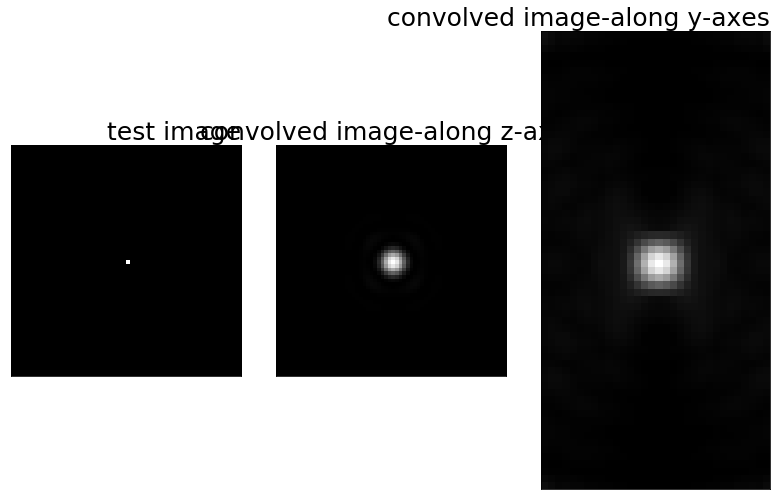

(576, 864, 3)

In [53]:
f = plt.figure(figsize=(12,8))

plt.subplot(131); 
temp = plt.imshow(myobject[:,:,m_d], cmap='gray'); 
plt.xticks([]); plt.yticks([]); plt.title('test image', fontsize=25, loc='right');
plt.subplot(132); 
temp = plt.imshow(myobject_conv[:,:,m_d], cmap='gray'); 
plt.xticks([]); plt.yticks([]); plt.title('convolved image-along z-axes', fontsize=25)
plt.subplot(133); 
temp = plt.imshow(np.max(myobject_conv, axis=0), cmap='gray'); 
plt.xticks([]); plt.yticks([]); plt.title('convolved image-along y-axes', fontsize=25, loc='right')

plt.subplots_adjust(left=0.02, wspace=0.15, top=0.92)
plt.show()

# If we haven't already shown or saved the plot, then we need to
# draw the figure first...
f.canvas.draw()

# Now we can save it to a numpy array.
data = np.fromstring(f.canvas.tostring_rgb(), dtype=np.uint8, sep='')
data = data.reshape(f.canvas.get_width_height()[::-1] + (3,))
data.shape

In [131]:
a,b = tf.Session().run([tf.constant([1,2,3]), tf.constant([4,5,6])])
print(a,b)

[1 2 3] [4 5 6]


In [17]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2801656681870403299, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6681632440
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 929224753502256188
 physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [30]:
print((otf.shape+(1,)))

(64, 64, 32, 1)
